In [180]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import sys  
sys.path.append('/Users/ae2772/Documents/Moocs/DL/CNN/')
import helper
import matplotlib.pyplot as plt
import importlib
importlib.reload(helper)
import itertools
import random
from PIL import Image



# hyperparameters

In [4]:
INIT_LR = 1E-3
BATCH_SIZE = 64
EPOCHS = 10

TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# helper functions

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

# Classification

In [121]:
##load data
path = '/Users/ae2772/Documents/Moocs/DL/CNN/classification/train/'

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor()])


trainData = ImageFolder(path, transform = transform)


##split in train and val
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)

(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

train_sampler = SubsetRandomSampler(list(range(1000)))
val_sampler = SubsetRandomSampler(list(range(100)))

trainDataLoader = DataLoader(trainData, batch_size = BATCH_SIZE,  sampler = train_sampler)
valDataLoader = DataLoader(valData, batch_size = BATCH_SIZE, sampler= val_sampler)


# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

<AxesSubplot: >

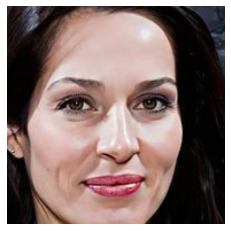

In [122]:
##show images
images, labels = next(iter(trainDataLoader))
helper.imshow(images[0], normalize=False)

In [239]:
class FaceNet(nn.Module):
    def __init__(self, block, layers, classes):
        super(FaceNet, self).__init__()
        self.inplanes = 64

        ## 1st CONV layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels =64, kernel_size = 7, stride = 2, padding = 3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)
        ## residual blocks
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, classes)
        self.logSoftmax = nn.LogSoftmax(dim = 1)
        
    def _make_layer(self, block, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample  = nn.Sequential(nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                            nn.BatchNorm2d(planes))
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        ## first conv
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        ## conv blocks
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        ##FCN layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        output = self.logSoftmax(x)
        return output

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels =out_channels, stride = stride, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels = out_channels, out_channels =out_channels, stride = 1, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.relu2 = nn.ReLU()

        
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu2(out)
        return out



In [42]:
## initialise model
model = FaceNet(ResidualBlock, [3,4,6,3], 
        classes = len(trainData.dataset.classes))

opt = optim.Adam(model.parameters(), lr = INIT_LR)
lossFn = nn.NLLLoss()

In [ ]:
for e in range(EPOCHS):
	model.train()
	totalTrainLoss = 0
	totalValLoss = 0
	trainCorrect = 0
	valCorrect = 0
    
	# loop over the training set
	for (x, y) in trainDataLoader:
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x)
		loss = lossFn(pred, y)
		# update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss 
		totalTrainLoss += loss
		trainCorrect += (pred.argmax(1) == y).type(
			torch.float).sum().item()

    # switch off for evaluation
	with torch.no_grad():
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x)
			totalValLoss += lossFn(pred, y)
			# calculate the number of correct predictions
			valCorrect += (pred.argmax(1) == y).type(
				torch.float).sum().item()
	
	print(trainCorrect, valCorrect)

# Verification

In [196]:
## image loader for pairs
class ImagePairDataset(Dataset):
    def __init__(self, pairs, transform = None):
        self.pairs = pairs
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

    def get_image(self, name):
        image = Image.open(name)
        return self.to_tensor(image)

    def __getitem__(self, index):
        name_1, name_2, label = self.pairs[index]
        
        image_1 = self.get_image(name_1)
        image_2 = self.get_image(name_2)


        if self.transform:
            image_1 = self.transform(image_1)
            image_2 = self.transform(image_2)
            
        return image_1, image_2, label
    

    def __len__(self):
        return len(self.pairs)

In [240]:
##generate positive and negative pairs
path = '/Users/ae2772/Documents/Moocs/DL/CNN/classification/train/'
samples = os.listdir(f'{path}')
positives = []
for s in samples[0:100]: 
    positive = list(itertools.combinations(os.listdir(f'{path}{s}'),2))
    positive = [(f'{path}{s}/{x0}', f'{path}{s}/{x1}', 1) for x0, x1 in positive]
    positives.extend(positive)

negatives = []
for _ in range(20000):
    s1, s2 = random.sample(samples[0:100],2)
    s1_s = random.sample(os.listdir(f'{path}{s1}'),1)
    s2_s = random.sample(os.listdir(f'{path}{s2}'),1)
    negatives.append((f'{path}{s1}/{s1_s[0]}', f'{path}{s2}/{s2_s[0]}', 0))

pairs = positives + negatives
random.shuffle(pairs)

In [241]:
trainData = ImagePairDataset(pairs)

##split in train and val
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)

(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

train_sampler = SubsetRandomSampler(list(range(1000)))
val_sampler = SubsetRandomSampler(list(range(100)))

trainDataLoader = DataLoader(trainData, batch_size = BATCH_SIZE,  sampler = train_sampler)
valDataLoader = DataLoader(valData, batch_size = BATCH_SIZE, sampler= val_sampler)


# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [270]:
class SiameseNetwork(nn.Module):
    def __init__(self, cnn):
        super(SiameseNetwork, self).__init__()
        self.CNN = cnn
        ##freeze previous params
        for param in self.CNN.parameters():
            param.requires_grad = False

        ## take all layers up to final
        self.CNN = nn.Sequential(*list(self.CNN.children())[:-2])
        self.fc = nn.Linear(512, 128)


    def forward(self, x1, x2):
        x1 = self.CNN(x1)
        x1 = torch.flatten(x1, 1)
        x2 = self.CNN(x2)
        x2 = torch.flatten(x2, 1)


        output1 = self.fc(x1)
        output2 = self.fc(x2)
        
        return (output1, output2)

In [274]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, label):
        # Calculate the Euclidean distance between the outputs
        distance = (output[0] - output[1]).pow(2).sum(1)
        # Calculate the contrastive loss based on the distance and the label
        loss = label * distance + (1 - label) * torch.clamp(self.margin - distance, min=0)
        loss = loss.mean()
        # Return the mean loss
        return loss

In [275]:
## initialise model
facenet = FaceNet(ResidualBlock, [3,4,6,3], 
        classes = 10)
model = SiameseNetwork(facenet)
opt = optim.Adam(model.parameters(), lr = INIT_LR)
lossFn = ContrastiveLoss(margin = 0)

In [ ]:
for e in range(EPOCHS):
	model.train()
	totalTrainLoss = 0
	totalValLoss = 0
	trainCorrect = 0
	valCorrect = 0
    
	# loop over the training set
	for (x1, x2, y) in trainDataLoader:
		# send the input to the device
		(x1, x2, y) = (x1.to(device), x2.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = model(x1, x2)
		loss = lossFn(pred, y)
		# update the weights
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss 
		totalTrainLoss += loss

    # switch off for evaluation
	with torch.no_grad():
		model.eval()
		# loop over the validation set
		for (x, y) in valDataLoader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = model(x1, x2)
			totalValLoss += lossFn(pred, y)
	